In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from osus_dataset import OSUSDataset
from util import get_csv_data, train, generate, generate_conversation
import numpy as np
import matplotlib.pyplot as plt
import torch

DATA_DIR = '../data_dir'
MODEL_DIR = 'model_dir'
SAVED_MODEL_PREFIX = 'bigboi'

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Importing the Model

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Importing the Test Dataset

In [5]:
train_data = get_csv_data(os.path.join(DATA_DIR, 'train'))

In [7]:
train_dataset = OSUSDataset(train_data, tokenizer, 1024) # OSUSDataset Obj

# Training the Model

In [14]:
model, loss_history = train(train_dataset, 
                  model, 
                  batch_size=1,
                  epochs=20, 
                  lr=2e-5,
                  output_dir=MODEL_DIR,
                  output_prefix=SAVED_MODEL_PREFIX,
                  save_model_on_epoch=True,
                  save_best_model=True
                  )

dataset <osus_dataset.OSUSDataset object at 0x7f2ffc1f9bb0>


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 0


Iteration: 3it [00:00,  8.88it/s]
Epoch:   0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 108.00 MiB (GPU 0; 6.00 GiB total capacity; 5.08 GiB already allocated; 0 bytes free; 5.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Visualizing the Data

In [ ]:
loss_history = np.array(loss_history)
epoch_nums = np.arange(1, len(loss_history) + 1)

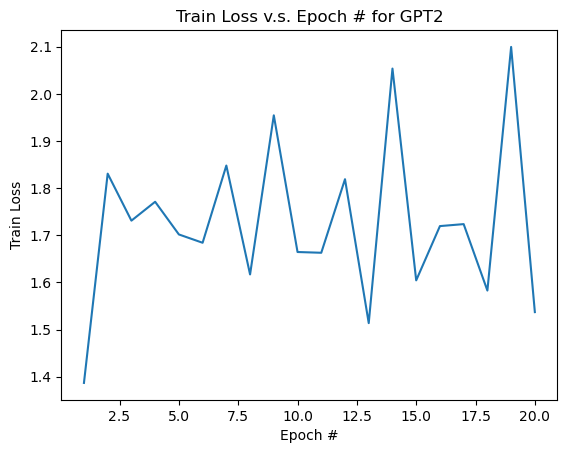

In [ ]:
plt.xlabel('Epoch #')
plt.ylabel('Train Loss')
plt.title('Train Loss v.s. Epoch # for GPT2')
plt.plot(epoch_nums, loss_history)

# Importing Best Model

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.load_state_dict(torch.load('model_dir/bigboi-best-1.pt'))

<All keys matched successfully>

# Comparing Best Model vs Regular GPT2 Accuracy using Auto-evaluation Metrics

In [4]:
from nltk.translate import bleu_score, meteor_score, nist_score
# perplexity, LSA

In [5]:
regular_model = GPT2LMHeadModel.from_pretrained('gpt2')

In [6]:
test_data = get_csv_data(os.path.join(DATA_DIR, 'test'))
test_dataset = OSUSDataset(test_data, tokenizer, 1024) # OSUSDataset Obj

In [7]:
def get_imposter_in_sentence(sentence: str):
    sent_list = sentence.split('\n')
    for sent in sent_list:
        if (sent.split('\t')[1] == 'imposter'):
            return sent.split('\t')[0]
        
def get_dead_player(sentence: str):
    remaining_players = ['Red', 'Green', 'Blue', 'Yellow']
    sent_list = sentence.split('\n')
    for sent in sent_list[:3]:
        remaining_players.remove(sent.split('\t')[0])
        
    return remaining_players[0]
        
test_data_info = [(x.split('\n')[0].split('\t')[0], get_imposter_in_sentence(x), get_dead_player(x)) for x in test_data]

In [8]:
generated_test_data = [generate_conversation(model, tokenizer, x[0], x[1], x[2]) for x in test_data_info]

100%|██████████| 1/1 [00:05<00:00,  5.93s/it]


In [9]:
bleu_scores = [bleu_score.sentence_bleu([' '.join(' '.join(test_point.split('\n')).split('\t'))], ' '.join(' '.join(gen_point.split('\n')).split('\t'))) for test_point, gen_point in zip(test_data, generated_test_data)]
nist_scores = [nist_score.sentence_nist([' '.join(' '.join(test_point.split('\n')).split('\t'))], ' '.join(' '.join(gen_point.split('\n')).split('\t'))) for test_point, gen_point in zip(test_data, generated_test_data)]
meteor_scores = [meteor_score.meteor_score([' '.join(' '.join(test_point.split('\n')).split('\t')).split(' ')], ' '.join(' '.join(gen_point.split('\n')).split('\t')).split(' ')) for test_point, gen_point in zip(test_data, generated_test_data)]

In [10]:
print('Avg. Bleu Score:', sum(bleu_scores) / len(bleu_scores))
print('Avg. Nist Score:', sum(nist_scores) / len(nist_scores))
print('Avg. Meteor Score:', sum(meteor_scores) / len(meteor_scores))

Avg. Bleu Score: 0.40379784205370994
Avg. Nist Score: 4.171610625296543
Avg. Meteor Score: 0.2359657919611683


In [13]:
generated_test_data_base_model = [generate_conversation(regular_model, tokenizer, x[0], x[1], x[2]) for x in test_data_info]

100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


In [14]:
bleu_scores_base = [bleu_score.sentence_bleu([' '.join(' '.join(test_point.split('\n')).split('\t'))], ' '.join(' '.join(gen_point.split('\n')).split('\t'))) for test_point, gen_point in zip(test_data, generated_test_data_base_model)]
nist_scores_base = [nist_score.sentence_nist([' '.join(' '.join(test_point.split('\n')).split('\t'))], ' '.join(' '.join(gen_point.split('\n')).split('\t'))) for test_point, gen_point in zip(test_data, generated_test_data_base_model)]
meteor_scores_base = [meteor_score.meteor_score([' '.join(' '.join(test_point.split('\n')).split('\t')).split(' ')], ' '.join(' '.join(gen_point.split('\n')).split('\t')).split(' ')) for test_point, gen_point in zip(test_data, generated_test_data_base_model)]

In [15]:
print('Avg. Bleu Score:', sum(bleu_scores_base) / len(bleu_scores_base))
print('Avg. Nist Score:', sum(nist_scores_base) / len(nist_scores_base))
print('Avg. Meteor Score:', sum(meteor_scores_base) / len(meteor_scores_base))

Avg. Bleu Score: 0.10175769407879076
Avg. Nist Score: 0.526868098212049
Avg. Meteor Score: 0.12456682638278682
